In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa.core as lc
import IPython.display as ipd

import dataset_loader.music_loader_stft

In [2]:
loader = dataset_loader.music_loader_stft.MusicLoaderSTFT('data/fma_xs', split='test')

input_data shape (2, 257, 126)
(257, 126) 42.597317 8.763822e-05 2.7595036
(257, 126) 48.84877 0.00027866315 2.6235359


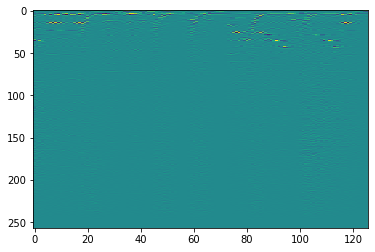

In [3]:
i = np.random.randint(len(loader))
sampling_rate = 8000

input_data, label = loader[i]
input_signal = loader.spec_to_audio(input_data)

real = input_data[0, :, :]
imag = input_data[1, :, :]
print('input_data shape', input_data.shape)
abs_spect = np.linalg.norm(input_data, axis=0)
print(real.shape, real.max(), real.mean(), real.std())
print(imag.shape, imag.max(), imag.mean(), imag.std())

plt.imshow(real, aspect='auto')

In [4]:
# Original audio

#signal = loader.get_raw(i)
#ipd.Audio(signal, rate=sampling_rate)

In [5]:
# Reconstructed from STFT, with phase information from original data

#reconstruct = loader.spec_to_audio(a, i)
#ipd.Audio(reconstruct, rate=sampling_rate)

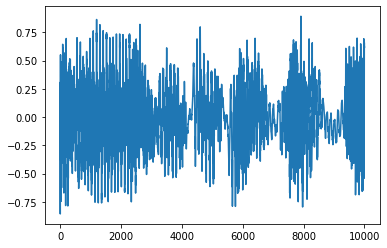

In [6]:
# Plot original vs reconstructed

#plt.plot(signal[:10000])
plt.plot(input_signal[:10000])

Input shape torch.Size([1, 2, 257, 126]) size 64764
Latent shape torch.Size([1, 4, 62, 29]) size 7192
Output shape torch.Size([1, 2, 257, 126]) size 64764
4.301696300506592
input mean, std 0.00018315038 2.6923783
output mean, std -0.011358828 1.7149628


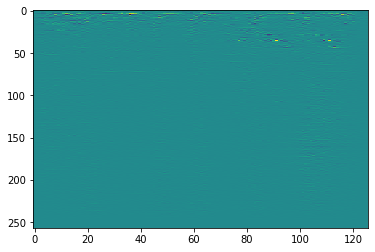

In [7]:
import os
import torch.utils
from torch.autograd import Variable
from models.frequency_autoencoder import FrequencyAutoencoder
from dataset_loader.music_loader_stft import MusicLoaderSTFT

model_dir = 'model_logs/'

model = FrequencyAutoencoder()
model.cuda()

checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

input_tensor = torch.from_numpy(np.expand_dims(input_data, axis=0))

input_tensor = Variable(input_tensor).cuda()
output_tensor, _ = model.forward(input_tensor)
loss = float(model.loss_criterion(input_tensor, output_tensor))

print(loss)

output = output_tensor.cpu().data.numpy()
output = output.squeeze()

plt.imshow(output[0, :, :], aspect='auto')

print("input mean, std", input_data.mean(), input_data.std())
print("output mean, std", output.mean(), output.std())

In [8]:
# Original audio

ipd.Audio(input_signal, rate=sampling_rate)

In [9]:
# Autoencoded compressed

reconstruct_no_phase = loader.spec_to_audio(output)
ipd.Audio(reconstruct_no_phase, rate=sampling_rate)

In [10]:
# Resampled to roughly 2kbps

resampled = lc.resample(input_signal, 8000, 2000)
ipd.Audio(resampled, rate=2000)

In [11]:
import soundfile

for i in range(10):
    rand_idx = np.random.randint(len(loader))
    input_data, label = loader[rand_idx]
    input_tensor = torch.from_numpy(np.expand_dims(input_data, axis=0))

    input_tensor = Variable(input_tensor).cuda()
    output_tensor, _ = model.forward(input_tensor)
    output = output_tensor.cpu().data.numpy()
    output = output.squeeze()
    
    
    input_signal = loader.spec_to_audio(input_data)
    reconstruct = loader.spec_to_audio(output)
    
    to_save = np.concatenate((input_signal, reconstruct))
    file_name = str(i) + '.wav'
    
    
    soundfile.write(file_name, to_save, sampling_rate)